<a href="https://colab.research.google.com/github/DarkTitan007/EDA-ON-WINE-REVIEWS/blob/main/EDA_ON_WINE_REVIEWS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CODEVITA LIVE INTERNSHIP**
BY - ABHISHEK J NAIR (Data science intern) 

DATASET- I HAVE TAKEN DATASET FROM KAGGLE

PROBLEM STATEMENT

1. Perform exploratory Data Analysis on Wine Reviews Dataset 

**Importing libraries**

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # getting future warnings for SGD classifier

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.svm import LinearSVC



In [3]:
X = pd.read_csv('wine-reviews.csv')
Xunmod = X
descript=X.description
X.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
# For the moment it looks like a number of the columns will be redundant, however I will re-introduce
# them slowly at later points to see how they impact classification. 
X = X.drop(['Unnamed: 0','description','designation', 'province','region_1','region_2','taster_name',
            'taster_twitter_handle','title','winery'],axis=1)

X.head()

,country,points,price,variety
0,Italy,87,NaN,White Blend
1,Portugal,87,15.0,Portuguese Red
2,US,87,14.0,Pinot Gris
3,US,87,13.0,Riesling
4,US,87,65.0,Pinot Noir


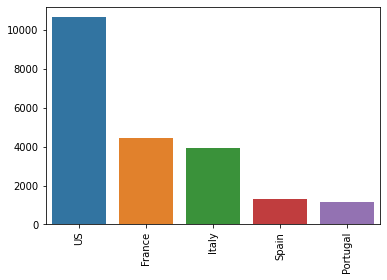

In [5]:
## Country
X.country = X.country.fillna('US') # Fill NaNs with the mode

countries = X.country.value_counts()
countries = countries[countries>1000]
plt.xticks(rotation=90)
sns.barplot(countries.index,countries.values);

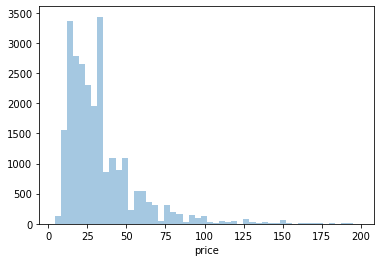

In [6]:
## Price
X.price = X.price.fillna(np.mean(X.price))
#print(X.price.unique())
sns.distplot(X.price[X.price<200],kde=False);

In [7]:
X.variety = X.variety.fillna('Other')
X.variety = X.variety.astype('category').cat.codes
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25861 entries, 0 to 25860
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  25861 non-null  object 
 1   points   25861 non-null  int64  
 2   price    25861 non-null  float64
 3   variety  25861 non-null  int16  
dtypes: float64(1), int16(1), int64(1), object(1)
memory usage: 656.8+ KB


0.5051400324407234

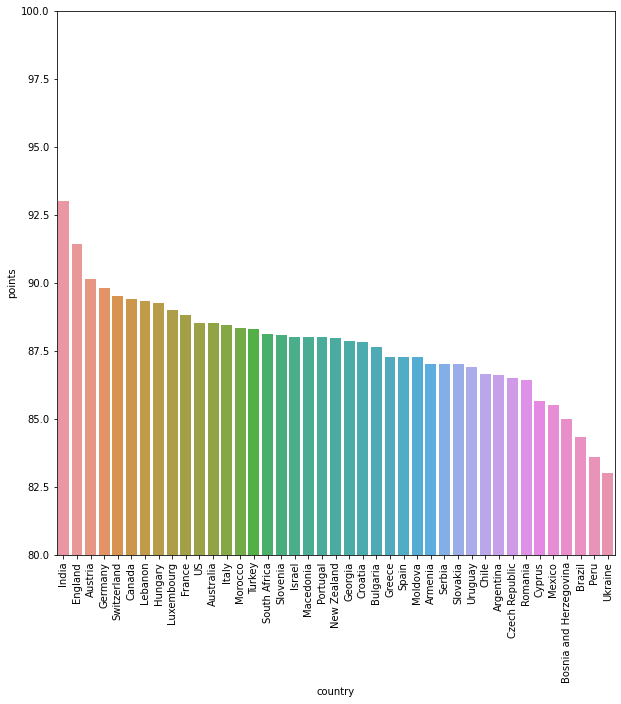

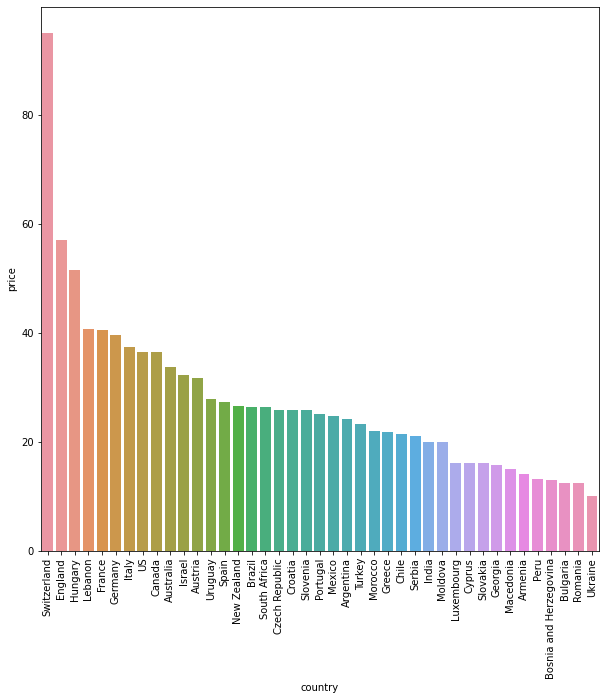

In [8]:
#Look at which country has the most expensive wine, and also which country scores the most points 
#(on average)

countryVsPoints = X.groupby(by=['country'], as_index=False)['points'].mean()
countryVsPoints = countryVsPoints.sort_values(['points'], ascending=False)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_ylim([80,100])
plt.xticks(rotation=90)
sns.barplot(countryVsPoints['country'],countryVsPoints['points'])

countryVsPrice = X.groupby(by=['country'], as_index=False)['price'].mean()
countryVsPrice = countryVsPrice.sort_values(['price'], ascending=False)
fig, ax = plt.subplots(figsize=(10,10))
plt.xticks(rotation=90)
sns.barplot(countryVsPrice['country'],countryVsPrice['price'])

countryVsPoints['points'].corr(countryVsPrice['price'])

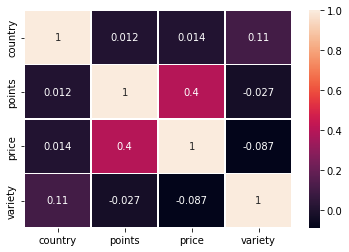

In [9]:
# For later

def encoder(data):
    '''Map the categorical variables to numbers to work with scikit learn'''
    for col in data.columns:
        if data.dtypes[col] == "object":
            le = preprocessing.LabelEncoder()
            le.fit(data[col])
            data[col] = le.transform(data[col])
    return data
X = encoder(X)
#correlation map
fig,ax = plt.subplots()
sns.heatmap(X.corr(), annot=True, linewidths=.5,ax=ax)

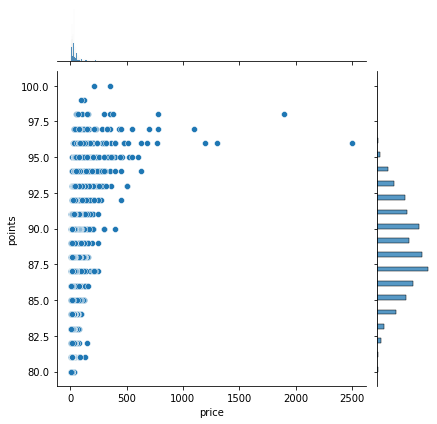

In [10]:
# It seems like the only think that really correlates so far is price and points, which makes sense. 
# Lets take a look at this distribution and see if we can't fit some regression to it.
ax = sns.jointplot(x="price", y="points", data=X);

In [11]:
# Lets work with the description statistic and see if this will correlate to something else
# Can I predict whether or not the wine will be rated >90 by the review?
tempX = Xunmod.drop('price', axis=1)
tempy = X.price
trainX, testX, trainY, testY = train_test_split(tempX,tempy)

clf = Pipeline([('vect', TfidfVectorizer()),
                ('clf', SGDClassifier(alpha=4e-6))
])

# Use a cross-validation grid search to find the best parameters
parameters = {}
gs_clf = GridSearchCV(clf, parameters)

gs_clf.fit(trainX.description,(trainY>90))
results=pd.DataFrame(gs_clf.cv_results_)
CVscore = np.mean(cross_val_score(gs_clf,testX.description,(testY>90)))
print(results)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
0       0.618723      0.059613         0.145861        0.004846     {}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0           0.948698           0.949472           0.958237           0.951792   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.956948         0.953029        0.003884                1  


In [12]:
print("The mean cross validated score is {0:.1f}%".format(100*CVscore))

The mean cross validated score is 95.7%


**THE END**